# Sentiment Analysis Using a Pre-trained Transformer

Sentiment Analysis is a method of classification in natural language processing which is able to classify the tone of words. In this work we will use a pre-trained transformer (BERT) to classify text. We will use the Squid Game Review Dataset to understand the current sentiment towards the show.


## 🔍 What is BERT?

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google. It is designed to understand the context of words by looking at **both the words before and after** a target word — making it bidirectional.

BERT is particularly powerful for tasks like sentiment analysis, question answering, and text classification, as it captures deep contextual relationships in language.

---

### How BERT Works 

- BERT is based on the **Transformer encoder** architecture.
- The model reads the entire sentence at once and uses **self-attention** to weigh the importance of each word relative to others.
- Each word is turned into a vector (embedding), and the model learns how these vectors interact in context.
- For classification tasks, a special `[CLS]` token is used, and its final representation is passed to a simple classifier layer.

---


### What is Self-Attention?

**Self-attention** is the core mechanism of Transformers. It allows the model to determine which words in a sentence are important to each other — regardless of their position.

For example, in the sentence  
> “The dog chased the cat because **it** was fast,”  
the model uses self-attention to help figure out whether “it” refers to “dog” or “cat”.

Technically, self-attention works by creating **three vectors** for each word: Query, Key, and Value. The model compares the **query** of one word to the **keys** of all other words to compute a set of attention scores. These scores are then used to create a weighted combination of **value** vectors — letting each word build a rich, context-aware representation based on the whole sentence.

---

### Why BERT is Effective for Sentiment Analysis

- Understands word meaning **based on full sentence context**
- Detects subtle emotions and **negations** (e.g., "not bad" ≠ "bad")
- Pre-trained on large corpora and can be fine-tuned on specific tasks with minimal data



## Section 1 : Exploring and Cleaning the Dataset

Here we will load the dataset taken from kaggle and explore it's contets. From this we will explore the current structure of the data and cleanse as appropriate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/reviews.csv")
df.head()

,Unnamed: 0,User_name,Review title,Review Rating,Review date,Review_body
0,0,Leofwine_draca,A new TV classic,10/10,9 October 2021,"Just finished up SQUID GAME, the Korean TV sho..."
1,1,kosmasp,Just a game,9/10,10 October 2021,"Well multiple games actually, but even that yo..."
2,2,Tweekums,Games to die for,10/10,11 October 2021,This runaway hit from South Korea is centred o...
3,3,FeastMode,"if you think this is good, PLEASE watch the ko...",5/10,9 October 2021,I went into this show knowing absolutely nothi...
4,4,Irishchatter,It started off strong but ended disoriented,7/10,8 October 2021,I honestly don't know wtf the main character n...


In [2]:
# Dropping the first column which is an unnamed index column
df.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
df.shape

(1185, 5)

In [4]:
# Count null values
df.isnull().sum()

User_name        0
Review title     0
Review Rating    0
Review date      0
Review_body      0
dtype: int64

In [5]:
# Dropping rows with Null Values
df.dropna(inplace=True)

In [6]:
df.shape

(1185, 5)

In [7]:
# Converting Review Rating to numeric
df["Review Rating"] = df["Review Rating"].apply(lambda x : int(x.split("/")[0]) / 10 * 100)

# Converting the Review Date to datetime
df["Review date"] = pd.to_datetime(df["Review date"], errors = "coerce")

df.head()

,User_name,Review title,Review Rating,Review date,Review_body
0,Leofwine_draca,A new TV classic,100.0,2021-10-09,"Just finished up SQUID GAME, the Korean TV sho..."
1,kosmasp,Just a game,90.0,2021-10-10,"Well multiple games actually, but even that yo..."
2,Tweekums,Games to die for,100.0,2021-10-11,This runaway hit from South Korea is centred o...
3,FeastMode,"if you think this is good, PLEASE watch the ko...",50.0,2021-10-09,I went into this show knowing absolutely nothi...
4,Irishchatter,It started off strong but ended disoriented,70.0,2021-10-08,I honestly don't know wtf the main character n...


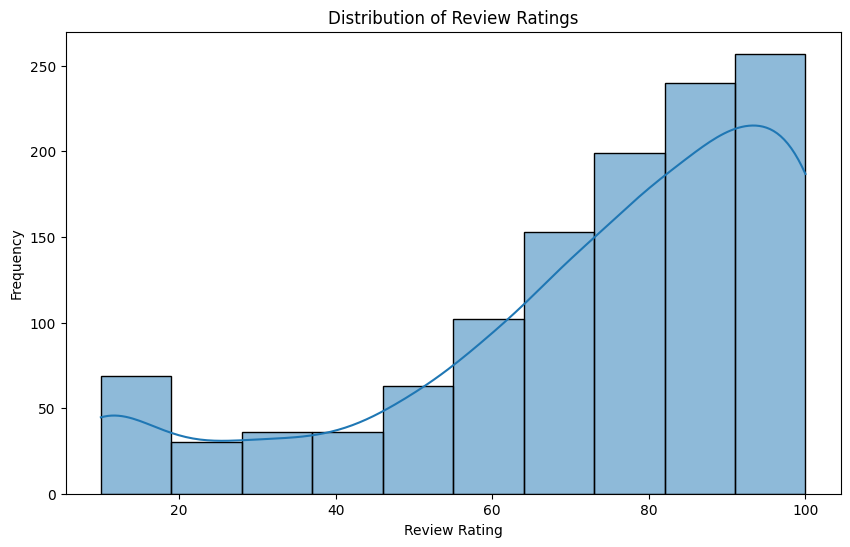

In [8]:
# Plotting distribution of Review Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df["Review Rating"], bins=10, kde=True)
plt.title("Distribution of Review Ratings")
plt.xlabel("Review Rating")
plt.ylabel("Frequency")
plt.show()

Ratings of the data have a negative skew. Here this indicates that more users rate Squid Game more positively, thus suggesting that the show was widely received by audiences.

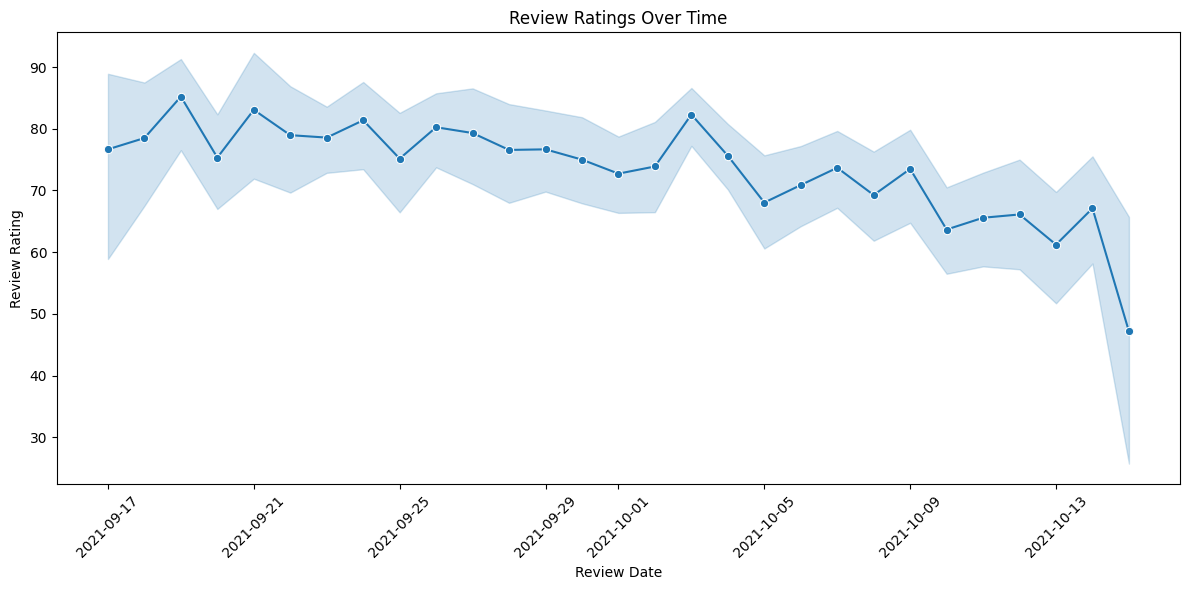

In [9]:
# Plotting ratings over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Review date", y="Review Rating", marker="o")
plt.title("Review Ratings Over Time")
plt.xlabel("Review Date")
plt.ylabel("Review Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As can be seen from the lineplot above, that whilst initially the review ratings were substantially high ratings and overtime the rating drops off. This observation can be rationalised via several reasons.

- **Initial Hype Fades** : Intial reviews come from viewers who are usually influenced by a show's marketing, leading to higher intial scores. As time progresses, more casual/critical viewers watch the show, and will tend scrutinise more thus providing less favorable ratings.

- **Overexposure** : Since Squid Game was a show which gained mass popularity over social media, exposure to marketing content and memes will have caused people to become sick of the show and provide backlash, thus contributing to lower ratings.

- **Increased Criticism Over Time** : As more people watch the show, it welcomes a more diversified set of opinions which may underpin flaws/shortcomings of the show, leading to lower ratings.

## Section 2 : Sentiment Analysis

In this code, we will use the pipeline method in transformers to conduct sentiment analysis using the distil-bert model from hugging face.

Here we will create a new feature called "Full Review" which will encapsulate both the review title and review body, which will be the text we perform sentiment analysis on.

In [10]:
"""
The pipeline method in HuggingFace enables us to use pre-trained models for various tasks, 
here it handles tokenization, model inference and post-processing.
"""

from transformers import pipeline, AutoTokenizer

# Creating full body of text for sentiment analysis
df["Full Review"] = df["Review title"] + ". " + df["Review_body"]

/Users/rizwannobeebux/Documents/product-feedback-analyzer/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/rizwannobeebux/Documents/product-feedback-analyzer/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
print(df["Full Review"][1])

Just a game. Well multiple games actually, but even that you may find ... not accurate. Now you may not look the same way at some games that are being played here. But with all the buzz right now, you've probably heard quite a bit about that already.If like you got into this without any spoilers (congrats by the way), then the show will be able to surprise quite a few times. Be it by the players themselves but also and even more so by how the story evolves. It may not end exactly how I would imagine ... but that can also be seen as a good thing I reckon.As a fan of Korean cinema I was curious about this anyway. And it did not dissapoint - at all. The acting is amazing, the effects are great ... and the story is as mature as it can get. With enough social commentary and critique to make this a great watch!
                
                    34 out of 61 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                 

In [12]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    truncation=True,          # <— enable automatic truncation
    max_length=512            # <— specify the hard limit
)

# Performing sentiment analysis
df["Sentiment"] = df["Full Review"].apply(lambda x: sentiment_pipeline(x)[0]['label'])
df["Sentiment Score"] = df["Full Review"].apply(lambda x: sentiment_pipeline(x)[0]['score'])
df.head()

/Users/rizwannobeebux/Documents/product-feedback-analyzer/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,User_name,Review title,Review Rating,Review date,Review_body,Full Review,Sentiment,Sentiment Score
0,Leofwine_draca,A new TV classic,100.0,2021-10-09,"Just finished up SQUID GAME, the Korean TV sho...","A new TV classic. Just finished up SQUID GAME,...",POSITIVE,0.998812
1,kosmasp,Just a game,90.0,2021-10-10,"Well multiple games actually, but even that yo...","Just a game. Well multiple games actually, but...",POSITIVE,0.998438
2,Tweekums,Games to die for,100.0,2021-10-11,This runaway hit from South Korea is centred o...,Games to die for. This runaway hit from South ...,POSITIVE,0.994197
3,FeastMode,"if you think this is good, PLEASE watch the ko...",50.0,2021-10-09,I went into this show knowing absolutely nothi...,"if you think this is good, PLEASE watch the ko...",NEGATIVE,0.971422
4,Irishchatter,It started off strong but ended disoriented,70.0,2021-10-08,I honestly don't know wtf the main character n...,It started off strong but ended disoriented. I...,NEGATIVE,0.977503


Text(0.5, 0, 'Sentiment Score')

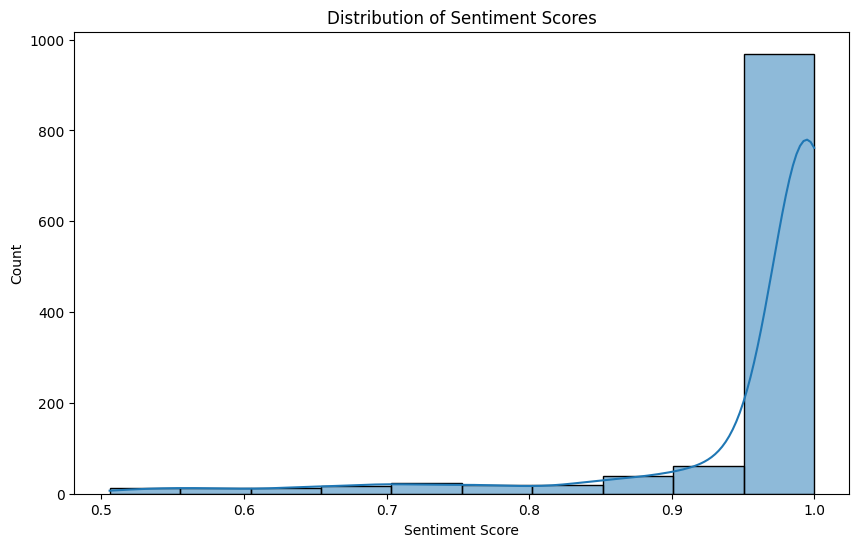

In [13]:
# Distribution of Sentiment Scores
plt.figure(figsize=(10, 6))
sns.histplot(df["Sentiment Score"], bins=10, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")

In [14]:
# Filter dataframe for sentiment scores between 0.6 and 0.8
df_filtered = df[(df["Sentiment Score"] >= 0.8) & (df["Sentiment Score"] <= 0.9)]
df_filtered.shape[0]

58

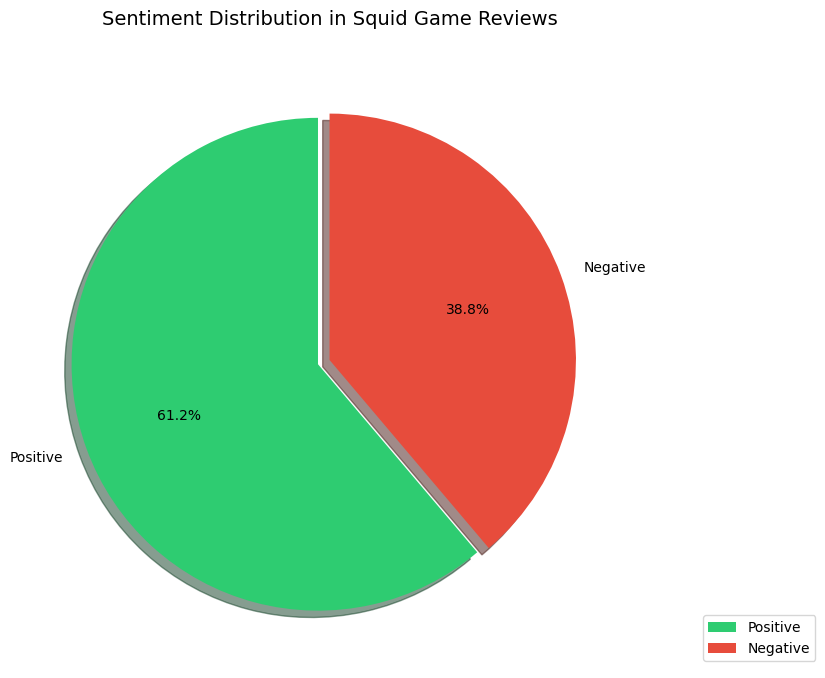

In [15]:
# Create a more visually appealing pie chart
plt.figure(figsize=(10, 8))

# Custom colors and explode for emphasis
colors = ['#2ecc71', '#e74c3c']  # Green for positive, red for negative
explode = (0.05, 0)  # Slight separation for positive sentiment

# Plot pie chart with percentages
df["Sentiment"].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    labels=['Positive', 'Negative']
)

# Customize appearance
plt.title("Sentiment Distribution in Squid Game Reviews", pad=20, fontsize=14)
plt.ylabel("")  # Remove y-label
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0))

plt.show()

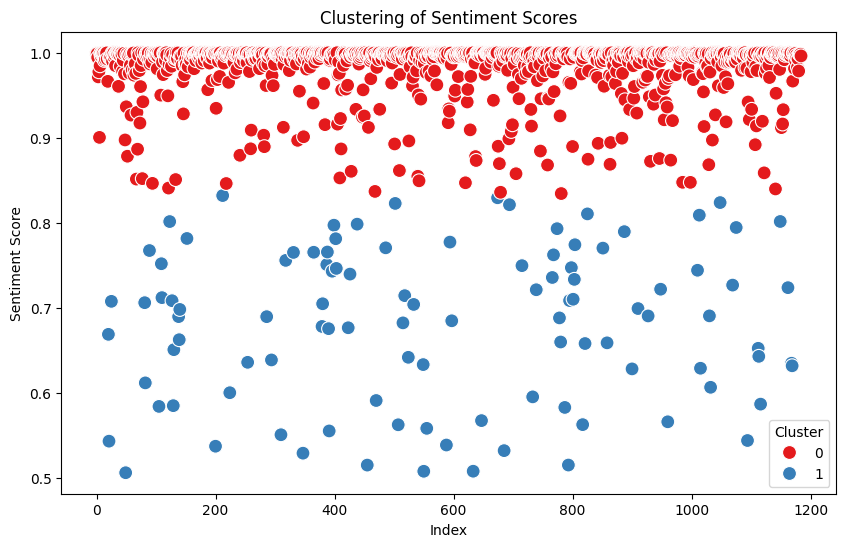

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Sentiment Score' column exists in the dataframe
# Prepare the data for clustering
sentiment_scores = df[['Sentiment Score']].dropna()

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 clusters for positive and negative
sentiment_scores['Cluster'] = kmeans.fit_predict(sentiment_scores)

# Add cluster labels back to the original dataframe
df['Cluster'] = sentiment_scores['Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sentiment_scores, x=sentiment_scores.index, y='Sentiment Score', hue='Cluster', palette='Set1', s=100)
plt.title('Clustering of Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend(title='Cluster')
plt.show()

In [18]:
# Calculate silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(sentiment_scores[['Sentiment Score']], sentiment_scores['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.88


As we can see, the clusters show very good separation between groups. Further works will need to include elucidating which reviews are misclassified. For the most part, the model generalises well to the reviews as indicated by the scatter plot and silhouette score of 0.88.